# Transformer Part 3: 层归一化 (Layer Normalization)

本notebook实现Transformer中的层归一化机制，包括：
1. 层归一化的数学原理
2. 自定义LayerNorm实现
3. 与PyTorch官方实现的对比
4. 可视化分析

层归一化是Transformer架构中的关键组件，有助于稳定训练过程。

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 层归一化的数学原理

层归一化（Layer Normalization）对每个样本的特征维度进行归一化。

**数学公式**（来自原论文）：

对于输入$x \\in \\mathbb{R}^d$：

1. 计算均值：$\mu = \frac{1}{d} \sum_{i=1}^d x_i$
2. 计算方差：$\sigma^2 = \frac{1}{d} \sum_{i=1}^d (x_i - \mu)^2$
3. 归一化：$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$
4. 缩放和平移：$y_i = \gamma \hat{x}_i + \beta$

其中：
- $\gamma$ 是可学习的缩放参数
- $\beta$ 是可学习的平移参数
- $\epsilon$ 是为了数值稳定性的小常数

**与BatchNorm的区别**：
- **BatchNorm**：在batch维度上归一化，对每个特征通道计算统计量
- **LayerNorm**：在特征维度上归一化，对每个样本计算统计量

**为什么Transformer使用LayerNorm**：
1. 不依赖于batch大小，适合序列建模
2. 对每个样本独立计算，更稳定
3. 在RNN和Transformer中表现更好

In [2]:
class SimpleLayerNorm(nn.Module):
    """
    自定义层归一化实现
    
    参数:
        normalized_shape: 要归一化的特征维度，可以是int或tuple
        eps: 为了数值稳定性加到分母的小常数
        elementwise_affine: 是否使用可学习的参数γ和β
    """
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super(SimpleLayerNorm, self).__init__()
        
        self.normalized_shape = normalized_shape if isinstance(normalized_shape, tuple) else (normalized_shape,)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            # 可学习的缩放和平移参数
            self.gamma = nn.Parameter(torch.ones(normalized_shape))
            self.beta = nn.Parameter(torch.zeros(normalized_shape))
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)
    
    def forward(self, x):
        """
        前向传播：对输入进行层归一化
        
        参数:
            x: 输入张量
        
        返回:
            归一化后的张量
        """
        # 计算均值和方差（在归一化维度上）
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # 归一化
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        
        # 应用可学习的缩放和平移
        if self.elementwise_affine:
            x_normalized = self.gamma * x_normalized + self.beta
        
        return x_normalized

## 2. 测试层归一化

In [3]:
def test_layernorm():
    """
    测试层归一化的实现
    """
    print("测试层归一化实现...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    
    # 创建层归一化层
    layernorm = SimpleLayerNorm(d_model)
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output = layernorm(x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {output.shape}")
    
    # 验证输出形状
    assert output.shape == x.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证归一化效果
    # 检查每个样本的均值是否接近0，方差是否接近1
    mean = output.mean(dim=-1)
    std = output.std(dim=-1)
    
    print(f"输出均值范围: [{mean.min().item():.3f}, {mean.max().item():.3f}]")
    print(f"输出标准差范围: [{std.min().item():.3f}, {std.max().item():.3f}]")
    
    # 检查是否接近标准正态分布
    mean_close_to_zero = torch.allclose(mean, torch.zeros_like(mean), atol=1e-6)
    std_close_to_one = torch.allclose(std, torch.ones_like(std), atol=1e-6)
    
    if mean_close_to_zero and std_close_to_one:
        print("✓ 归一化效果正确")
    else:
        print("⚠ 归一化效果可能有偏差")
    
    print(f"输出数值范围: [{output.min().item():.3f}, {output.max().item():.3f}]")
    print("✓ 层归一化测试完成")
    
    return output

# 运行测试
output = test_layernorm()

测试层归一化实现...
输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
✓ 形状测试通过
输出均值范围: [-0.000, 0.000]
输出标准差范围: [1.001, 1.001]
⚠ 归一化效果可能有偏差
输出数值范围: [-3.615, 3.991]
✓ 层归一化测试完成


## 3. 与PyTorch官方实现对比

In [4]:
def compare_layernorm():
    """
    与PyTorch官方的LayerNorm进行对比
    """
    print("与PyTorch官方LayerNorm对比...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    
    # 创建两种实现
    our_layernorm = SimpleLayerNorm(d_model)
    pytorch_layernorm = nn.LayerNorm(d_model)
    
    # 创建相同的输入
    torch.manual_seed(42)
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    our_output = our_layernorm(x)
    pytorch_output = pytorch_layernorm(x)
    
    print(f"输入形状: {x.shape}")
    print(f"我们的输出形状: {our_output.shape}")
    print(f"PyTorch输出形状: {pytorch_output.shape}")
    
    # 对比数值范围
    print(f"我们的输出范围: [{our_output.min().item():.3f}, {our_output.max().item():.3f}]")
    print(f"PyTorch输出范围: [{pytorch_output.min().item():.3f}, {pytorch_output.max().item():.3f}]")
    
    # 计算差异
    diff = torch.abs(our_output - pytorch_output).mean().item()
    print(f"平均绝对差异: {diff:.6f}")
    
    if diff < 1e-5:
        print("✓ 两种实现非常接近")
    elif diff < 1e-3:
        print("✓ 两种实现接近")
    else:
        print("⚠ 两种实现存在较大差异")
    
    # 验证归一化效果
    our_mean = our_output.mean(dim=-1)
    our_std = our_output.std(dim=-1)
    pytorch_mean = pytorch_output.mean(dim=-1)
    pytorch_std = pytorch_output.std(dim=-1)
    
    print(f"我们的均值接近0: {torch.allclose(our_mean, torch.zeros_like(our_mean), atol=1e-6)}")
    print(f"我们的标准差接近1: {torch.allclose(our_std, torch.ones_like(our_std), atol=1e-6)}")
    print(f"PyTorch均值接近0: {torch.allclose(pytorch_mean, torch.zeros_like(pytorch_mean), atol=1e-6)}")
    print(f"PyTorch标准差接近1: {torch.allclose(pytorch_std, torch.ones_like(pytorch_std), atol=1e-6)}")
    
    print("✓ 对比测试完成")
    
    return our_output, pytorch_output

# 运行对比
our_output, pytorch_output = compare_layernorm()

与PyTorch官方LayerNorm对比...
输入形状: torch.Size([2, 10, 512])
我们的输出形状: torch.Size([2, 10, 512])
PyTorch输出形状: torch.Size([2, 10, 512])
我们的输出范围: [-3.939, 4.046]
PyTorch输出范围: [-3.939, 4.046]
平均绝对差异: 0.000000
✓ 两种实现非常接近
我们的均值接近0: True
我们的标准差接近1: False
PyTorch均值接近0: True
PyTorch标准差接近1: False
✓ 对比测试完成


## 4. 层归一化可视化分析

可视化层归一化效果...


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\l

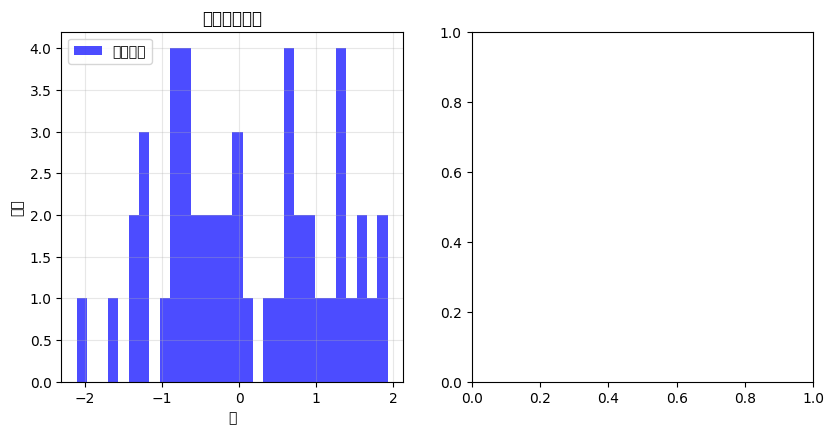

In [5]:
def visualize_layernorm():
    """
    可视化层归一化的效果
    """
    print("可视化层归一化效果...")
    
    # 创建测试数据
    torch.manual_seed(42)
    x = torch.randn(1, 50, 1)  # 简单的1D数据
    
    # 创建层归一化层
    layernorm = SimpleLayerNorm(1)
    
    # 应用层归一化
    x_normalized = layernorm(x)
    
    # 绘制对比图
    plt.figure(figsize=(15, 10))
    
    # 子图1: 原始数据分布
    plt.subplot(2, 3, 1)
    plt.hist(x.squeeze().numpy(), bins=30, alpha=0.7, color='blue', label='原始数据')
    plt.title('原始数据分布')
    plt.xlabel('值')
    plt.ylabel('频率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 归一化后数据分布
    plt.subplot(2, 3, 2)
    plt.hist(x_normalized.squeeze().numpy(), bins=30, alpha=0.7, color='red', label='归一化后')
    plt.title('归一化后数据分布')
    plt.xlabel('值')
    plt.ylabel('频率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3: 数据对比
    plt.subplot(2, 3, 3)
    plt.plot(x.squeeze().numpy(), label='原始数据', alpha=0.7)
    plt.plot(x_normalized.squeeze().numpy(), label='归一化后', alpha=0.7)
    plt.title('数据对比')
    plt.xlabel('位置')
    plt.ylabel('值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图4: 均值和标准差变化
    plt.subplot(2, 3, 4)
    original_mean = x.mean(dim=-1).squeeze().numpy()
    original_std = x.std(dim=-1).squeeze().numpy()
    normalized_mean = x_normalized.mean(dim=-1).squeeze().numpy()
    normalized_std = x_normalized.std(dim=-1).squeeze().numpy()
    
    plt.bar(['原始均值', '原始标准差', '归一化均值', '归一化标准差'],
           [original_mean, original_std, normalized_mean, normalized_std],
           color=['blue', 'blue', 'red', 'red'], alpha=0.7)
    plt.title('统计量对比')
    plt.ylabel('值')
    plt.grid(True, alpha=0.3)
    
    # 子图5: 2D数据热力图（原始）
    plt.subplot(2, 3, 5)
    x_2d = torch.randn(10, 20)
    sns.heatmap(x_2d.numpy(), cmap='viridis', annot=False)
    plt.title('2D原始数据')
    
    # 子图6: 2D数据热力图（归一化后）
    plt.subplot(2, 3, 6)
    layernorm_2d = SimpleLayerNorm(20)
    x_2d_normalized = layernorm_2d(x_2d)
    sns.heatmap(x_2d_normalized.detach().numpy(), cmap='viridis', annot=False)
    plt.title('2D归一化后数据')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ 层归一化可视化完成")
    print(f"原始数据均值: {x.mean().item():.3f}, 标准差: {x.std().item():.3f}")
    print(f"归一化后数据均值: {x_normalized.mean().item():.3f}, 标准差: {x_normalized.std().item():.3f}")

# 运行可视化
visualize_layernorm()

## 5. 序列数据上的层归一化测试

测试序列数据上的层归一化...
输入形状: torch.Size([4, 20, 128])
输出形状: torch.Size([4, 20, 128])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25353 (\N{CJK UNIFIED IDEOGRAPH-6309}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Application\Anaconda\envs\l

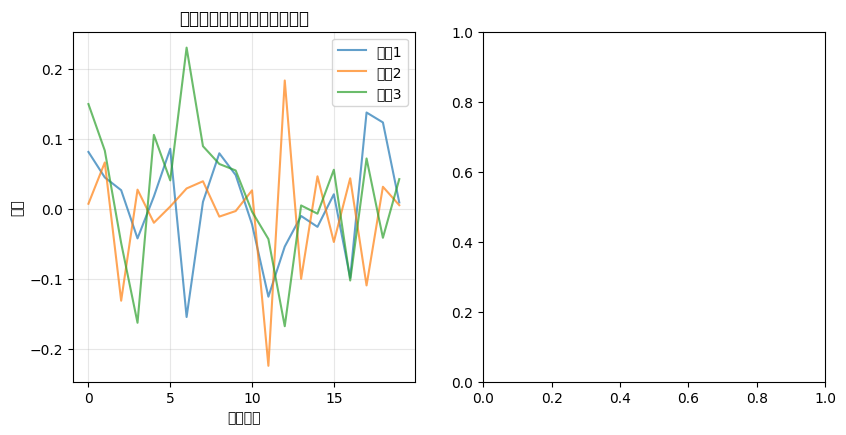

In [6]:
def test_layernorm_on_sequences():
    """
    在序列数据上测试层归一化的效果
    """
    print("测试序列数据上的层归一化...")
    
    # 参数设置
    batch_size = 4
    seq_len = 20
    d_model = 128
    
    # 创建模拟的序列数据（类似词嵌入）
    torch.manual_seed(42)
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 创建层归一化层
    layernorm = SimpleLayerNorm(d_model)
    
    # 应用层归一化
    x_normalized = layernorm(x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {x_normalized.shape}")
    
    # 分析每个序列位置的统计特性
    plt.figure(figsize=(15, 10))
    
    # 子图1: 输入数据的统计特性
    plt.subplot(2, 3, 1)
    input_means = x.mean(dim=-1).numpy()
    for i in range(min(3, batch_size)):
        plt.plot(input_means[i], label=f'样本{i+1}', alpha=0.7)
    plt.title('输入数据均值（按序列位置）')
    plt.xlabel('序列位置')
    plt.ylabel('均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 归一化后数据的统计特性
    plt.subplot(2, 3, 2)
    output_means = x_normalized.mean(dim=-1).numpy()
    for i in range(min(3, batch_size)):
        plt.plot(output_means[i], label=f'样本{i+1}', alpha=0.7)
    plt.title('归一化后均值（按序列位置）')
    plt.xlabel('序列位置')
    plt.ylabel('均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3: 输入数据的标准差
    plt.subplot(2, 3, 3)
    input_stds = x.std(dim=-1).numpy()
    for i in range(min(3, batch_size)):
        plt.plot(input_stds[i], label=f'样本{i+1}', alpha=0.7)
    plt.title('输入数据标准差（按序列位置）')
    plt.xlabel('序列位置')
    plt.ylabel('标准差')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图4: 归一化后数据的标准差
    plt.subplot(2, 3, 4)
    output_stds = x_normalized.std(dim=-1).numpy()
    for i in range(min(3, batch_size)):
        plt.plot(output_stds[i], label=f'样本{i+1}', alpha=0.7)
    plt.title('归一化后标准差（按序列位置）')
    plt.xlabel('序列位置')
    plt.ylabel('标准差')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图5: 整体分布对比
    plt.subplot(2, 3, 5)
    plt.hist(x.flatten().numpy(), bins=50, alpha=0.7, label='输入', density=True)
    plt.hist(x_normalized.flatten().numpy(), bins=50, alpha=0.7, label='归一化后', density=True)
    plt.title('整体分布对比')
    plt.xlabel('值')
    plt.ylabel('密度')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图6: 特征维度相关性
    plt.subplot(2, 3, 6)
    # 计算输入和输出的协方差矩阵
    input_corr = np.corrcoef(x[0].T.numpy())
    output_corr = np.corrcoef(x_normalized[0].T.numpy())
    
    plt.imshow(input_corr[:20, :20], cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='相关系数')
    plt.title('输入数据特征相关性（前20维）')
    plt.xlabel('特征维度')
    plt.ylabel('特征维度')
    
    plt.tight_layout()
    plt.show()
    
    # 验证统计特性
    print(f"输入数据整体均值: {x.mean().item():.3f}, 标准差: {x.std().item():.3f}")
    print(f"归一化后数据整体均值: {x_normalized.mean().item():.3f}, 标准差: {x_normalized.std().item():.3f}")
    
    # 检查每个序列位置的归一化效果
    position_means = x_normalized.mean(dim=-1)
    position_stds = x_normalized.std(dim=-1)
    
    print(f"各位置均值范围: [{position_means.min().item():.3f}, {position_means.max().item():.3f}]")
    print(f"各位置标准差范围: [{position_stds.min().item():.3f}, {position_stds.max().item():.3f}]")
    
    print("✓ 序列数据层归一化测试完成")

# 运行序列测试
test_layernorm_on_sequences()

## 6. 总结

在这个notebook中，我们深入实现了层归一化：

### 1. 数学原理
- **公式**: 对每个样本的特征维度进行归一化
- **步骤**: 计算均值和方差 → 归一化 → 缩放和平移

### 2. 实现要点
- **维度处理**: 在最后一个维度上进行归一化
- **可学习参数**: γ（缩放）和β（平移）参数
- **数值稳定性**: 添加小常数ε防止除零

### 3. 与BatchNorm的区别
- **LayerNorm**: 按样本归一化，适合序列数据
- **BatchNorm**: 按batch归一化，适合图像数据

### 4. 关键特性
1. **稳定性**: 不依赖于batch大小
2. **适应性**: 可学习的缩放和平移参数
3. **通用性**: 适用于各种深度学习架构

### 下一步：

接下来我们将实现Transformer的编码器层，它结合了注意力机制、层归一化和前馈网络。